# Flux comparison
In FIG. 4 , the authors compared subsystems by selecting the most de-regulated reactions across cell types (LG and HG). I think They optimized to max biomass each of the 7 models  (they generated 7 FBA solutions) and then they computed the average of each flux across cell lines of the same family.

However, they selected one of the many solutions that respect max biomass growth. I suggest to:

1. Impose biomass at its upper bound for each model (LB = UB*0.90 to avoid solver numerical issues)
2. Run flux sampling with OPTGP (cobrapy) with thinning = 100 and 1k samples per cell line
3. DO not 'summarize' flux probability distributions with a simple average, but use more advanced methods. The objective here is to identify the most different reactions across the two cancer families. You could run non parametric statistical tests such as mann-whitney to check if two probability distributions are significantly different or not. You have 3 cells vs 2 cells (all pair combinations), so you could perform this test only on reactions belonging to core subsystems such as glycolysis, TCA cycle pentophosphate etc.. in order to redure the number of compared distribution per cell couple.
4. Once you identified the top-n most different probability distributions (reaction fluxes) across cells of different type, you could plot them with boxplots as the authors did 
5. It might be interesting to check if we have 'less differences' in distributions of cells belonging to the same family.

In [1]:
from cobra.sampling import sample
import pandas as pd
import numpy as np
import pandas as pd
from cobra.io.json import load_json_model
import numpy as np
from cobra.flux_analysis import flux_variability_analysis
import os


In [2]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi'
model.objective = 'BIOMASS_reaction'

Set parameter Username
Set parameter LicenseID to value 2732828
Academic license - for non-commercial use only - expires 2026-11-04


# Seperating reactions into pathways

In [3]:
subsystem_dict = {}

for r in model.reactions:
    # get subsystem safely
    s = (getattr(r, "subsystem", "") or "").strip()

    # if it contains "/", keep only the first part
    if "/" in s:
        s = s.split("/")[0].strip()   # take text before "/" and remove spaces

    s = s.lower()

    # skip empty subsystems
    if not s:
        continue

    # add reaction to that subsystem list
    subsystem_dict.setdefault(s, []).append(r.id)

In [4]:
category_keywords = {
    "Glycolysis": [
        "glycolysis", "gluconeogenesis"
    ],
    
    "TCA": [
        "tca", "citric acid", "krebs"
    ],
    
    "Pentose Phosphate Pathway": [
        "pentose phosphate", "ppp"
    ],
    
    "Amino acid metabolism": [
        "amino acid",
        "tyrosine", "phenylalanine", "tryptophan",
        "lysine", "leucine", "isoleucine", "valine",
        "methionine", "cysteine", "serine", "threonine",
        "histidine", "arginine", "ornithine", "proline",
        "glutamate", "glutamine", "aspartate", "asparagine",
        "alanine", "glycine"
    ],
    
    "Nucleotide metabolism": [
        "nucleotide", "purine", "pyrimidine", "deoxynucleotide", "dntp"
    ],
    
    "Fatty acid metabolism": [
        "fatty acid", "beta oxidation", "beta-oxidation",
        "acyl", "acyl-coa"
    ],
    
    "Lipid metabolism": [
        "lipid", "phospholipid", "sphingolipid", "glycerolipid"
    ],
}

In [5]:
keys = list(subsystem_dict.keys())
print(keys)

['transport, mitochondrial', 'transport, extracellular', 'transport, lysosomal', 'extracellular exchange', 'vitamin d metabolism', 'transport, endoplasmic reticular', 'beta-alanine metabolism', 'glycine, serine, alanine, and threonine metabolism', 'methionine and cysteine metabolism', 'lysine metabolism', 'tryptophan metabolism', 'tyrosine metabolism', 'ubiquinone synthesis', 'taurine and hypotaurine metabolism', 'cytochrome metabolism', 'steroid metabolism', 'sphingolipid metabolism', 'o-glycan metabolism', 'blood group synthesis', 'glutamate metabolism', 'valine, leucine, and isoleucine metabolism', 'fatty acid oxidation', 'transport, peroxisomal', 'propanoate metabolism', 'transport, golgi apparatus', 'aminosugar metabolism', 'transport, nuclear', 'urea cycle', 'citric acid cycle', 'vitamin b2 metabolism', 'nucleotide interconversion', 'arginine and proline metabolism', 'purine synthesis', 'keratan sulfate synthesis', 'alanine and aspartate metabolism', 'n-glycan degradation', 'bile

In [6]:
selected = {cat: [] for cat in category_keywords}

In [7]:
for subsystem_name, rxns in subsystem_dict.items():
    name_lower = subsystem_name.lower()

    for category, keywords in category_keywords.items():
        if any(kw in name_lower for kw in keywords):
            selected[category].extend(rxns)

In [8]:
for cat, rxns in selected.items():
    print(f"{cat}: {len(set(rxns))} reactions")

Glycolysis: 42 reactions
TCA: 20 reactions
Pentose Phosphate Pathway: 41 reactions
Amino acid metabolism: 439 reactions
Nucleotide metabolism: 273 reactions
Fatty acid metabolism: 1200 reactions
Lipid metabolism: 369 reactions


In [9]:
for rxn_id in selected["Lipid metabolism"]:
    rxn = model.reactions.get_by_id(rxn_id)
    print(rxn_id, " → ", rxn.subsystem)

A4GALTc  →  Sphingolipid metabolism
A4GALTg  →  Sphingolipid metabolism
B3GALT3g  →  Sphingolipid metabolism
B3GALT42g  →  Sphingolipid metabolism
B3GNT31g  →  Sphingolipid metabolism
B3GNT34g  →  Sphingolipid metabolism
B3GNT37g  →  Sphingolipid metabolism
B3GNT39g  →  Sphingolipid metabolism
DHCRD2  →  Sphingolipid metabolism
DSAT  →  Sphingolipid metabolism
GALGT2  →  Sphingolipid metabolism
GALGT3  →  Sphingolipid metabolism
GAO1g  →  Sphingolipid metabolism
GBA  →  Sphingolipid metabolism
GBGT1  →  Sphingolipid metabolism
GLAl  →  Sphingolipid metabolism
GLB1  →  Sphingolipid metabolism
NAGAlby  →  Sphingolipid metabolism
SBPP3er  →  Sphingolipid metabolism
SGPL12r  →  Sphingolipid metabolism
SLCBK1  →  Sphingolipid metabolism
SMPD3g  →  Sphingolipid metabolism
SMS  →  Sphingolipid metabolism
SPHK21c  →  Sphingolipid metabolism
ST3GAL21g  →  Sphingolipid metabolism
ST3GAL22g  →  Sphingolipid metabolism
ST3GAL23g  →  Sphingolipid metabolism
ST6GALNAC21  →  Sphingolipid metabolism
S

In [10]:
reactions_by_category = {
    "glycolysis": selected["Glycolysis"],
    "tca": selected["TCA"],
    "ppp": selected["Pentose Phosphate Pathway"],
    "amino_acid": selected["Amino acid metabolism"],
    "nucleotide": selected["Nucleotide metabolism"],
    "fatty_acid": selected["Fatty acid metabolism"],
    "lipid": selected["Lipid metabolism"],
}

- index = rxn_id
- columns = cell_id

# Flux sampling

In [11]:
low_grade = {
    'ACH-000520': '59M',
    'ACH-000542': 'HEYA8',
    'ACH-000091': 'OV56'
}
high_grade = {
    'ACH-000256': 'COV318',
    'ACH-000713': 'CAOV3',
    'ACH-000116': 'OAW28'
}

In [12]:
"""os.makedirs("data/flux_sampling_data_new", exist_ok=True)"""

'os.makedirs("data/flux_sampling_data_new", exist_ok=True)'

In [13]:
def run_sampling_for_group(group_dict, suffix):
    for cl_id, cl_name in group_dict.items():
        print(f"\n=== Processing {cl_name} ({cl_id}) — {suffix} ===")

        # Load FVA file
        fva_path = f'./data/fva_rnaseq_{cl_id}_{suffix}.csv'
        df_fva = pd.read_csv(fva_path, index_col=0)

        # Clean invalid or missing bounds
        df_fva[['minimum', 'maximum']] = df_fva[['minimum', 'maximum']].fillna(0.0)
        invalid = df_fva['minimum'] > df_fva['maximum']
        df_fva.loc[invalid, ['minimum', 'maximum']] = 0.0

        #  Inject reaction bounds into model
        for rxn_id, row in df_fva.iterrows():
            model.reactions.get_by_id(rxn_id).bounds = (row['minimum'], row['maximum'])

        # Check feasibility
        sol = model.optimize()
        print(f"   Status: {sol.status}, Growth: {sol.objective_value}")

        #  Fix biomass at 90% of UB
        UB = model.reactions.get_by_id('BIOMASS_reaction').upper_bound
        model.reactions.get_by_id('BIOMASS_reaction').bounds = (0.9 * UB, UB)

        # 7) Run flux sampling
        print("   Running OPTGP sampling...")
        samples = sample(model, n=1000, method="optgp", thinning=100, seed=42)

        # 8) Save CSV
        out_path = f"./data/flux_sampling_data/flux_samples_{cl_name}_{suffix}.csv"
        samples.to_csv(out_path)

        print(f"   Saved → {out_path}")

In [14]:
"""run_sampling_for_group(low_grade, "LG")
run_sampling_for_group(high_grade, "HG")"""

'run_sampling_for_group(low_grade, "LG")\nrun_sampling_for_group(high_grade, "HG")'

# Flux Distribution comparisions

In [15]:
"""LG = {
    "59M": pd.read_csv("./data/flux_sampling_data/flux_sampling_LG_59M.csv", index_col=0),
    "HEYA8": pd.read_csv("./data/flux_sampling_data/flux_sampling_LG_HEYA8.csv", index_col=0),
    "OV56": pd.read_csv("./data/flux_sampling_data/flux_sampling_LG_OV56.csv", index_col=0)
}

HG = {
    "COV318": pd.read_csv("./data/flux_sampling_data/flux_sampling_HG_COV318.csv", index_col=0),
    "CAOV3": pd.read_csv("./data/flux_sampling_data/flux_sampling_HG_CAOV3.csv", index_col=0),
    "OAW28": pd.read_csv("./data/flux_sampling_data/flux_sampling_HG_OAW28.csv", index_col=0)
}"""

LG = {
    "59M": pd.read_csv("data/flux_sampling_data/flux_sampling_LG_59M.csv", index_col=0),
    "HEYA8": pd.read_csv("data/flux_sampling_data/flux_sampling_LG_HEYA8.csv", index_col=0),
    "OV56": pd.read_csv("data/flux_sampling_data/flux_sampling_LG_OV56.csv", index_col=0)
}

HG = {
    "COV318": pd.read_csv("data/flux_sampling_data/flux_sampling_HG_COV318.csv", index_col=0),
    "CAOV3": pd.read_csv("data/flux_sampling_data/flux_sampling_HG_CAOV3.csv", index_col=0),
    "OAW28": pd.read_csv("data/flux_sampling_data/flux_sampling_HG_OAW28.csv", index_col=0)
}

## Option 1

In [16]:
rxns = reactions_by_category["glycolysis"]

In [17]:
from scipy.stats import mannwhitneyu

results = []

for rxn in rxns:
    for lg_name, lg_df in LG.items():
        for hg_name, hg_df in HG.items():
            
            # extract distributions
            lg_values = lg_df[rxn].dropna()
            hg_values = hg_df[rxn].dropna()
            
            if len(lg_values) == 0 or len(hg_values) == 0:
                continue
            
            # Mann-Whitney test (non-parametric, distribution vs distribution)
            stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")
            
            results.append([rxn, lg_name, hg_name, stat, pval])


In [18]:
df_stats = pd.DataFrame(results, columns=["reaction", "LG", "HG", "U_stat", "p_value"])

In [19]:
df_stats

,reaction,LG,HG,U_stat,p_value
0,ALCD2y,59M,COV318,0.0,0.000000
1,ALCD2y,59M,CAOV3,0.0,0.000000
2,ALCD2y,59M,OAW28,2213.0,0.000000
3,ALCD2y,HEYA8,COV318,0.0,0.000000
4,ALCD2y,HEYA8,CAOV3,0.0,0.000000
...,...,...,...,...,...
373,AGPOP,HEYA8,CAOV3,0.0,0.000000
374,AGPOP,HEYA8,OAW28,331.0,0.000000
375,AGPOP,OV56,COV318,0.0,0.000000
376,AGPOP,OV56,CAOV3,1023.0,0.000000


In [20]:
from statsmodels.stats.multitest import multipletests

df_stats["p_adjusted"] = multipletests(df_stats["p_value"], method="fdr_bh")[1]

In [21]:
signif = df_stats[df_stats["p_adjusted"] < 0.01]
freq = signif.groupby("reaction").size().sort_values(ascending=False)

In [22]:
signif_sorted = signif.sort_values(by="p_adjusted", ascending=True)
print(signif_sorted)

     reaction     LG      HG     U_stat   p_value  p_adjusted
0      ALCD2y    59M  COV318        0.0  0.000000    0.000000
188  HMR_7749   OV56   OAW28  1000000.0  0.000000    0.000000
376     AGPOP   OV56   CAOV3     1023.0  0.000000    0.000000
342      PYK4    59M  COV318     8666.0  0.000000    0.000000
341      PYK3   OV56   OAW28  1000000.0  0.000000    0.000000
..        ...    ...     ...        ...       ...         ...
92      r0355    59M   OAW28   541346.0  0.001366    0.001399
195      ACSm   OV56  COV318   541235.0  0.001407    0.001437
306    G3PD2m    59M  COV318   459964.0  0.001933    0.001969
139    ALDD2x  HEYA8   CAOV3   463435.0  0.004632    0.004707
204    ALCD2x   OV56  COV318   535385.0  0.006140    0.006223

[373 rows x 6 columns]


## Option 2

In [23]:
results_2 = []

for rxn in rxns:
    for lg_name, lg_df in LG.items():
        for hg_name, hg_df in HG.items():
            
            # extract distributions
            lg_values = lg_df[rxn].dropna()
            hg_values = hg_df[rxn].dropna()
            
            # skip if empty
            if len(lg_values) == 0 or len(hg_values) == 0:
                continue
            
            # mean flux values
            mean_lg = lg_values.mean()
            mean_hg = hg_values.mean()
            
            # ---- Fold Difference (FD) ----
            # FD = | (mean_lg - mean_hg) / mean_hg |
            if mean_hg == 0:
                FD = np.nan  # avoid division by zero
            else:
                FD = abs((mean_lg - mean_hg) / mean_hg)
            
            # ---- Mann–Whitney U Test ----
            stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")
            
            results_2.append([
                rxn, lg_name, hg_name,
                stat, pval, mean_lg, mean_hg, FD
            ])

df_stats_2 = pd.DataFrame(results_2, columns=[
    "reaction", "LG", "HG",
    "U_stat", "p_value",
    "mean_LG", "mean_HG", "fold_change"
])

In [24]:
df_stats_2

,reaction,LG,HG,U_stat,p_value,mean_LG,mean_HG,fold_change
0,ALCD2y,59M,COV318,0.0,0.000000,1.708023e-08,4.937532e-08,0.654073
1,ALCD2y,59M,CAOV3,0.0,0.000000,1.708023e-08,5.664380e-08,0.698462
2,ALCD2y,59M,OAW28,2213.0,0.000000,1.708023e-08,4.213798e-08,0.594659
3,ALCD2y,HEYA8,COV318,0.0,0.000000,2.696971e-08,4.937532e-08,0.453782
4,ALCD2y,HEYA8,CAOV3,0.0,0.000000,2.696971e-08,5.664380e-08,0.523872
...,...,...,...,...,...,...,...,...
373,AGPOP,HEYA8,CAOV3,0.0,0.000000,1.659835e+02,3.184086e+02,0.478709
374,AGPOP,HEYA8,OAW28,331.0,0.000000,1.659835e+02,2.513565e+02,0.339649
375,AGPOP,OV56,COV318,0.0,0.000000,2.472524e+02,4.355200e+02,0.432282
376,AGPOP,OV56,CAOV3,1023.0,0.000000,2.472524e+02,3.184086e+02,0.223475


In [25]:
df_stats_2["p_adjusted"] = multipletests(df_stats_2["p_value"], method="fdr_bh")[1]

In [26]:
signif = df_stats_2[df_stats_2["p_adjusted"] < 0.01]
signif

,reaction,LG,HG,U_stat,p_value,mean_LG,mean_HG,fold_change,p_adjusted
0,ALCD2y,59M,COV318,0.0,0.000000,1.708023e-08,4.937532e-08,0.654073,0.000000
1,ALCD2y,59M,CAOV3,0.0,0.000000,1.708023e-08,5.664380e-08,0.698462,0.000000
2,ALCD2y,59M,OAW28,2213.0,0.000000,1.708023e-08,4.213798e-08,0.594659,0.000000
3,ALCD2y,HEYA8,COV318,0.0,0.000000,2.696971e-08,4.937532e-08,0.453782,0.000000
4,ALCD2y,HEYA8,CAOV3,0.0,0.000000,2.696971e-08,5.664380e-08,0.523872,0.000000
...,...,...,...,...,...,...,...,...,...
373,AGPOP,HEYA8,CAOV3,0.0,0.000000,1.659835e+02,3.184086e+02,0.478709,0.000000
374,AGPOP,HEYA8,OAW28,331.0,0.000000,1.659835e+02,2.513565e+02,0.339649,0.000000
375,AGPOP,OV56,COV318,0.0,0.000000,2.472524e+02,4.355200e+02,0.432282,0.000000
376,AGPOP,OV56,CAOV3,1023.0,0.000000,2.472524e+02,3.184086e+02,0.223475,0.000000


In [27]:
# 50% cutoff = FD >= 0.50
signif_50 = df_stats_2[df_stats_2["fold_change"] >= 0.2]
signif_50


,reaction,LG,HG,U_stat,p_value,mean_LG,mean_HG,fold_change,p_adjusted
0,ALCD2y,59M,COV318,0.0,0.0,1.708023e-08,4.937532e-08,0.654073,0.0
1,ALCD2y,59M,CAOV3,0.0,0.0,1.708023e-08,5.664380e-08,0.698462,0.0
2,ALCD2y,59M,OAW28,2213.0,0.0,1.708023e-08,4.213798e-08,0.594659,0.0
3,ALCD2y,HEYA8,COV318,0.0,0.0,2.696971e-08,4.937532e-08,0.453782,0.0
4,ALCD2y,HEYA8,CAOV3,0.0,0.0,2.696971e-08,5.664380e-08,0.523872,0.0
...,...,...,...,...,...,...,...,...,...
372,AGPOP,HEYA8,COV318,0.0,0.0,1.659835e+02,4.355200e+02,0.618884,0.0
373,AGPOP,HEYA8,CAOV3,0.0,0.0,1.659835e+02,3.184086e+02,0.478709,0.0
374,AGPOP,HEYA8,OAW28,331.0,0.0,1.659835e+02,2.513565e+02,0.339649,0.0
375,AGPOP,OV56,COV318,0.0,0.0,2.472524e+02,4.355200e+02,0.432282,0.0


## Option 3

In [28]:
# Statistical Threshold (Adjusted P-value / Q-value)
FDR_Q_VALUE_CUTOFF = 0.01
# Effect Size Threshold (Log2 Fold Change equivalent to your 20% change)
LOG2_FC_CUTOFF = 0.26 

all_results_data = []

for rxn in rxns:
    for lg_name, lg_df in LG.items():
        for hg_name, hg_df in HG.items():
            
            # extract distributions
            lg_values = lg_df[rxn].dropna()
            hg_values = hg_df[rxn].dropna()
            
            if len(lg_values) < 3 or len(hg_values) < 3:
                # Skip if too few observations for robust test
                continue
            
            # Calculate the means for log2FC calculation
            mean_lg = lg_values.mean()
            mean_hg = hg_values.mean()

            # Handle division by zero for log2FC: use a small pseudo-count or check for zero
            # Here, we check for near-zero means for stability (a standard log2FC practice)
            if mean_lg > 0 and mean_hg > 0:
                # Calculate Log2 Fold Change (HG vs LG)
                # log2(HG / LG)
                log2_fc = np.log2(mean_hg / mean_lg)
            else:
                # If one or both means are zero or negative, set log2_fc to NaN or a large value 
                # to mark it, and filter later. For now, use NaN.
                log2_fc = np.nan
            
            # Mann-Whitney U test (non-parametric, distribution vs distribution)
            stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")
            
            # Store data for the final DataFrame
            all_results_data.append({
                'reaction': rxn,
                'group_a': lg_name,
                'group_b': hg_name,
                'U_statistic': stat,
                'raw_p_value': pval,
                'log2_FC': log2_fc
            })

# Convert the list of results into a DataFrame
df_results = pd.DataFrame(all_results_data)


# We use the Benjamini/Hochberg method to calculate the False Discovery Rate (FDR)
# This generates the adjusted p-value (q-value)
reject, qvals, _, _ = multipletests(
    pvals=df_results['raw_p_value'], 
    alpha=FDR_Q_VALUE_CUTOFF, # The alpha is used internally for testing
    method='fdr_bh' # Benjamini/Hochberg method
)

# Add the Q-values to the DataFrame
df_results['q_value'] = qvals


# A hit must satisfy both the statistical and the effect size criteria:
# 1. q_value must be less than the FDR cutoff (e.g., 0.05)
# 2. The absolute log2_FC must be greater than the magnitude cutoff (e.g., 0.26)
significant_and_substantial_hits = df_results[
    (df_results['q_value'] <= FDR_Q_VALUE_CUTOFF) & 
    (df_results['log2_FC'].abs() >= LOG2_FC_CUTOFF)
]

# The final result DataFrame is 'significant_and_substantial_hits'
print(f"Total tests performed: {len(df_results)}")
print(f"Significant and substantial hits found: {len(significant_and_substantial_hits)}")
print("\n--- Example Significant Hits ---")
print(significant_and_substantial_hits.head())

Total tests performed: 378
Significant and substantial hits found: 231

--- Example Significant Hits ---
  reaction group_a group_b  U_statistic  raw_p_value   log2_FC  q_value
0   ALCD2y     59M  COV318          0.0          0.0  1.531462      0.0
1   ALCD2y     59M   CAOV3          0.0          0.0  1.729590      0.0
2   ALCD2y     59M   OAW28       2213.0          0.0  1.302793      0.0
3   ALCD2y   HEYA8  COV318          0.0          0.0  0.872450      0.0
4   ALCD2y   HEYA8   CAOV3          0.0          0.0  1.070578      0.0


## Automated version

In [29]:
results = []

# Iterate across all pathways
for pathway, reactions in reactions_by_category.items():

    for rxn in reactions:  # only reactions in this pathway

        for lg_name, lg_df in LG.items():
            for hg_name, hg_df in HG.items():

                # extract distributions
                if rxn not in lg_df.columns or rxn not in hg_df.columns:
                    continue

                lg_values = lg_df[rxn].dropna()
                hg_values = hg_df[rxn].dropna()

                # skip empty
                if len(lg_values) == 0 or len(hg_values) == 0:
                    continue

                # compute means
                mean_lg = lg_values.mean()
                mean_hg = hg_values.mean()

                if mean_lg > 0 and mean_hg > 0:
                    # Calculate Log2 Fold Change (HG vs LG)
                    # log2(HG / LG)
                    log2_fc = np.log2(mean_hg / mean_lg)
                else:
                    # If one or both means are zero or negative, set log2_fc to NaN or a large value 
                    # to mark it, and filter later. For now, use NaN.
                    log2_fc = np.nan

                # Mann-Whitney U test
                stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")

                results.append([
                    pathway, rxn, lg_name, hg_name,
                    stat, pval, mean_lg, mean_hg, log2_fc
                ])

# Build DataFrame
df_stats = pd.DataFrame(results, columns=[
    "pathway", "reaction", "LG", "HG",
    "U_stat", "p_value", "mean_LG", "mean_HG", "fold_change"
])

# Multiple testing correction
df_stats["p_adjusted"] = multipletests(df_stats["p_value"], method="fdr_bh")[1]

# Keep significant results
signif = df_stats[df_stats["p_adjusted"] < 0.01].copy()

# -----------------------
#  TOP 10 PER PATHWAY
# -----------------------
top5_per_pathway = (
    signif
    .sort_values(by="fold_change", ascending=True)
    .groupby("pathway")
    .head(5)
    .reset_index(drop=True)
)

top5_per_pathway


,pathway,reaction,LG,HG,U_stat,p_value,mean_LG,mean_HG,fold_change,p_adjusted
0,lipid,ACHEe,OV56,OAW28,1000000.0,0.000000e+00,9.763585,6.044054e-09,-30.589247,0.000000e+00
1,lipid,HMR_0641,OV56,CAOV3,1000000.0,0.000000e+00,4.620670,5.902610e-09,-29.544102,0.000000e+00
2,lipid,HMR_0641,OV56,OAW28,1000000.0,0.000000e+00,4.620670,6.447164e-09,-29.416790,0.000000e+00
3,lipid,ACHEe,OV56,CAOV3,1000000.0,0.000000e+00,9.763585,1.434041e-08,-29.342749,0.000000e+00
4,amino_acid,GluForTx,OV56,CAOV3,1000000.0,0.000000e+00,50.733030,9.696796e-08,-28.962770,0.000000e+00
5,lipid,HMR_0844,HEYA8,COV318,1000000.0,0.000000e+00,3.243217,9.288347e-09,-28.379357,0.000000e+00
6,amino_acid,GluForTx,59M,CAOV3,1000000.0,0.000000e+00,15.651596,9.696796e-08,-27.266154,0.000000e+00
7,fatty_acid,3HADICOAx,OV56,OAW28,1000000.0,0.000000e+00,0.264345,2.389112e-09,-26.721373,0.000000e+00
8,fatty_acid,3HADPACx,OV56,OAW28,1000000.0,0.000000e+00,0.264345,2.389112e-09,-26.721373,0.000000e+00
9,fatty_acid,FAOXC12DCC10DCx,OV56,OAW28,1000000.0,0.000000e+00,1.817173,2.192391e-08,-26.304615,0.000000e+00


In [55]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
results = []

# Iterate across all pathways
for pathway, reactions in reactions_by_category.items():

    for rxn in reactions:  # only reactions in this pathway

        for lg_name, lg_df in LG.items():
            for hg_name, hg_df in HG.items():

                # extract distributions
                if rxn not in lg_df.columns or rxn not in hg_df.columns:
                    continue

                lg_values = lg_df[rxn].dropna()
                hg_values = hg_df[rxn].dropna()

                # skip empty
                if len(lg_values) == 0 or len(hg_values) == 0:
                    continue

                # compute means
                mean_lg = lg_values.mean()
                mean_hg = hg_values.mean()

                # Fold Difference FD = |(mean_lg - mean_hg) / mean_hg|
                if mean_hg == 0:
                    FD = np.nan
                else:
                    FD = abs((mean_lg - mean_hg) / mean_hg)

                # Mann-Whitney U test
                stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")

                results.append([
                    pathway, rxn, lg_name, hg_name,
                    stat, pval, mean_lg, mean_hg, FD
                ])

# Build DataFrame
df_stats = pd.DataFrame(results, columns=[
    "pathway", "reaction", "LG", "HG",
    "U_stat", "p_value", "mean_LG", "mean_HG", "fold_change"
])

# Multiple testing correction
df_stats["p_adjusted"] = multipletests(df_stats["p_value"], method="fdr_bh")[1]

# Keep significant results
signif = df_stats[(df_stats["p_adjusted"] < 0.01) & (df_stats["fold_change"] > 0.90)].copy()

In [56]:
top5_per_pathway = (
    signif
    .sort_values(by="fold_change", ascending=False)
    .groupby("pathway")
    .head(5)
    .reset_index(drop=True)
)
top5_per_pathway


,pathway,reaction,LG,HG,U_stat,p_value,mean_LG,mean_HG,fold_change,p_adjusted
0,lipid,GALGT4,OV56,COV318,1000000.0,0.000000e+00,0.317355,-1.211306e-10,2.619939e+09,0.000000e+00
1,lipid,ST6GALNAC27,OV56,COV318,1000000.0,0.000000e+00,0.317355,-1.211306e-10,2.619939e+09,0.000000e+00
2,lipid,B3GALT44g,OV56,COV318,1000000.0,0.000000e+00,0.317355,-1.211306e-10,2.619939e+09,0.000000e+00
3,lipid,GALGT3,59M,COV318,1000000.0,0.000000e+00,0.360861,-2.215100e-10,1.629093e+09,0.000000e+00
4,lipid,B3GALT43g,59M,COV318,1000000.0,0.000000e+00,0.360861,-2.215100e-10,1.629093e+09,0.000000e+00
5,amino_acid,GluForTx,OV56,CAOV3,1000000.0,0.000000e+00,50.733030,9.696796e-08,5.231937e+08,0.000000e+00
6,amino_acid,GluForTx,59M,CAOV3,1000000.0,0.000000e+00,15.651596,9.696796e-08,1.614100e+08,0.000000e+00
7,fatty_acid,3HADPACx,OV56,OAW28,1000000.0,0.000000e+00,0.264345,2.389112e-09,1.106457e+08,0.000000e+00
8,fatty_acid,3HADICOAx,OV56,OAW28,1000000.0,0.000000e+00,0.264345,2.389112e-09,1.106457e+08,0.000000e+00
9,fatty_acid,FAOXC12DCC10DCx,OV56,OAW28,1000000.0,0.000000e+00,1.817173,2.192391e-08,8.288543e+07,0.000000e+00


In [32]:
def build_cellline_pathway_dict(group_dict, top5_per_pathway):
    """
    group_dict: LG or HG (a dict mapping cell line name -> flux df)
    top5_per_pathway: df with selected reactions (pathway + reaction columns)
    
    Returns:
        dict mapping each cell line to:
            dict[pathway] -> df with flux values (samples × top 5 reactions)
    """
    
    output = {}   # final big dictionary: cell_line -> { pathway: df }

    # --- Loop through each cell line (LG or HG) ---
    for cell_line, flux_df in group_dict.items():

        cell_dict = {}  # { pathway: df }
        
        # For each pathway, get the list of top 5 reactions
        for pathway in top5_per_pathway["pathway"].unique():
            
            # reactions selected for this pathway
            rxns = top5_per_pathway.loc[
                top5_per_pathway["pathway"] == pathway, "reaction"
            ].tolist()

            # keep only reactions that are present in the flux dataframe
            rxns = [r for r in rxns if r in flux_df.columns]

            # build a df with rows = samples, columns = 5 reactions
            if rxns:
                cell_dict[pathway] = flux_df[rxns].copy()

        output[cell_line] = cell_dict

    return output


In [57]:
LG["59M"]
LG

{'59M':      24_25DHVITD3tm  25HVITD3t      COAtl  EX_5adtststerone_e  \
 0          0.036521   0.709319  45.260521            0.072090   
 1          0.039121   0.707917  39.600044            0.071947   
 2          0.039089   0.707323  37.903778            0.065803   
 3          0.035923   0.709030  37.991038            0.062751   
 4          0.033207   0.682011  37.825996            0.078666   
 ..              ...        ...        ...                 ...   
 995        0.120440   0.740407   3.084707            0.120115   
 996        0.122628   0.685514   3.122992            0.118145   
 997        0.122451   0.684662   3.070970            0.115416   
 998        0.119052   0.787824   2.835021            0.114874   
 999        0.116832   0.764886   2.646207            0.114877   
 
      EX_5adtststerones_e    EX_5fthf_e  EX_5htrp_e  EX_5mthf_e     EX_5thf_e  \
 0               0.050733 -2.405421e-08    0.105986   51.659498  3.653280e-09   
 1               0.050632 -2.402187e-

In [39]:
LG_pathway_dicts = build_cellline_pathway_dict(LG, top5_per_pathway)

In [38]:
print(LG_pathway_dicts)

{'59M': {'fatty_acid':      HMR_2989  DESAT22_1p    ACChex  HMR_3115  HMR_2946
0    0.236743    2.154750 -0.868070  8.731166  0.219631
1    0.236275    2.845277 -0.866355  8.657968  0.219196
2    0.236076    2.843013 -1.490837  8.392105  0.219012
3    0.236646    2.849270 -1.493430  7.610339  0.219541
4    0.235697    2.838620 -1.545229  9.137949  0.218661
..        ...         ...       ...       ...       ...
995  0.479428    2.818886 -0.668964  4.065638  6.240136
996  0.480195    2.163227 -0.670546  4.171351  6.241544
997  0.479048    2.338680 -0.665724  4.005153  6.239439
998  0.481005    1.998325 -0.651041  3.732638  6.243061
999  0.480704    2.105895 -0.650419  3.504599  6.242498

[1000 rows x 5 columns], 'amino_acid':      AADSACYCL    LPCOXp  3OHGLUTACm  TD2GLTRCOAm  3HGLUTCOAm
0     4.475622  4.475622    2.514043     2.514043    2.514043
1     2.984183  2.984183    1.704285     1.704285    1.704285
2     3.244891  3.244891    2.235936     2.235936    2.235936
3     3.201748  3

In [44]:
list_LG_names =list(LG_pathway_dicts.keys())


In [47]:
for key in list_LG_names:
    subkeys = LG_pathway_dicts[key].keys()
    list_pathways= list(subkeys)

In [48]:
list_pathways

['fatty_acid', 'amino_acid', 'nucleotide', 'glycolysis', 'lipid', 'ppp', 'tca']

In [49]:
LG_pathway_dicts["59M"]['fatty_acid']

,HMR_2989,DESAT22_1p,ACChex,HMR_3115,HMR_2946
0,0.236743,2.154750,-0.868070,8.731166,0.219631
1,0.236275,2.845277,-0.866355,8.657968,0.219196
2,0.236076,2.843013,-1.490837,8.392105,0.219012
3,0.236646,2.849270,-1.493430,7.610339,0.219541
4,0.235697,2.838620,-1.545229,9.137949,0.218661
...,...,...,...,...,...
995,0.479428,2.818886,-0.668964,4.065638,6.240136
996,0.480195,2.163227,-0.670546,4.171351,6.241544
997,0.479048,2.338680,-0.665724,4.005153,6.239439
998,0.481005,1.998325,-0.651041,3.732638,6.243061


In [51]:
df_long = LG_pathway_dicts["59M"]['fatty_acid'].melt(var_name="reaction", value_name="flux")
df_long


,reaction,flux
0,HMR_2989,0.236743
1,HMR_2989,0.236275
2,HMR_2989,0.236076
3,HMR_2989,0.236646
4,HMR_2989,0.235697
...,...,...
4995,HMR_2946,6.240136
4996,HMR_2946,6.241544
4997,HMR_2946,6.239439
4998,HMR_2946,6.243061


In [35]:
HG_pathway_dicts = build_cellline_pathway_dict(HG, top5_per_pathway)

In [ ]:
for key in 

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

In [52]:
import seaborn as sns

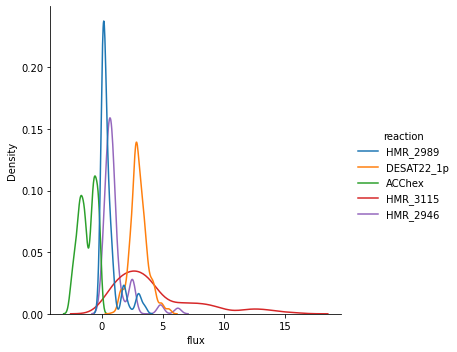

In [53]:
sns.displot(df_long, x="flux", hue="reaction", kind="kde")